In [4]:
import os
import random
import requests
import warnings
from datetime import datetime

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats 

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# df = pd.read_csv(r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\raw\twitter_x_forecast.csv')

# Define the file paths
path1 = r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\raw\twitter_x_forecast.csv'
path2 = r'C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\raw\twitter_x_forecast.csv'

# Check which path exists and read CSV
if os.path.exists(path1):
    df = pd.read_csv(path1) 
elif os.path.exists(path2):
    df = pd.read_csv(path2)   
else:
    # Raise a FileNotFoundError if neither path is valid
    raise FileNotFoundError("❌ No valid data file found in either specified path.")




In [6]:
df.head(5)

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,30.3,0.1,4,6,16.6,51,10,2022,47,1
1,2022-06-11,41.0,30.8,0.2,5,6,25.3,51,12,2022,42,1
2,2022-06-12,39.8,29.5,0.0,6,6,16.7,3,5,2022,45,3
3,2022-06-13,40.2,29.5,0.0,0,6,13.3,3,15,2022,45,3
4,2022-06-14,39.2,30.0,8.6,1,6,19.0,63,16,2022,52,0


In [7]:
df.shape

(1228, 12)

### Outlier Detection Z-score

In [8]:
# Step 1: Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Step 2: Compute Z-scores (use ddof=0 to avoid NaN issues)
z_scores = np.abs(stats.zscore(numeric_df, nan_policy='omit'))

# Convert to DataFrame for visualization
z_scores_df = pd.DataFrame(z_scores, columns=numeric_df.columns)

# Step 3: Define threshold (try 3.0 or 3.5 — 3.9 is too high)
threshold = 3.9

# Step 4: Identify and remove outliers
filtered_entries = (z_scores_df < threshold).all(axis=1)
df_cleaned = df[filtered_entries].reset_index(drop=True)

# Outlier DataFrame (rows where any feature exceeds threshold)
outlier_df = df[~filtered_entries].reset_index(drop=True)


In [9]:
df_cleaned.head(2)

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,30.3,0.1,4,6,16.6,51,10,2022,47,1
1,2022-06-11,41.0,30.8,0.2,5,6,25.3,51,12,2022,42,1


In [10]:
df_cleaned.shape

(1200, 12)

In [11]:
df_cleaned.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'precip_mm', 'day_of_week', 'month',
       'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'year',
       'relative_humidity_2m_mean', 'weather_label'],
      dtype='object')

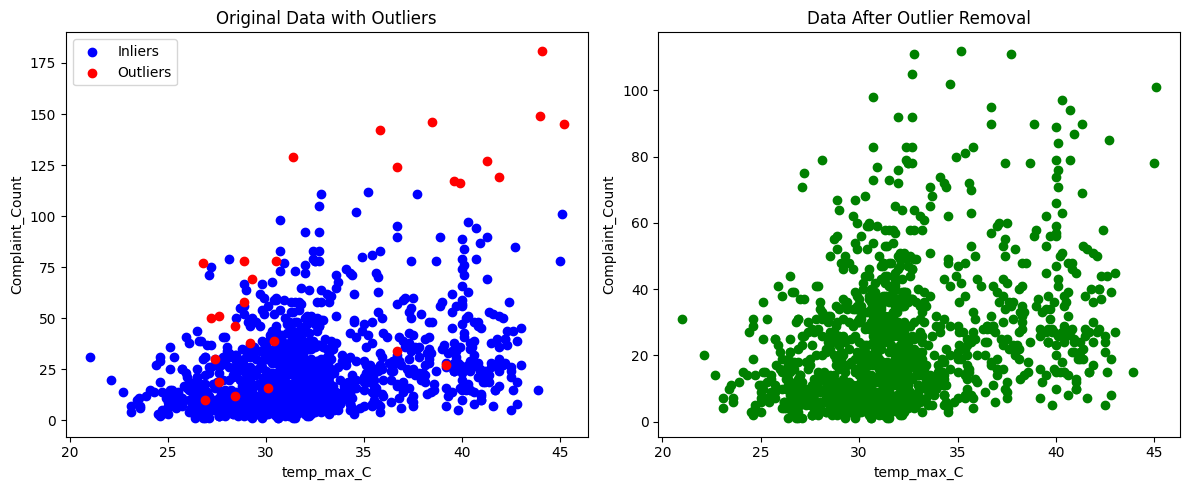

In [12]:
import matplotlib.pyplot as plt

# Step 5: Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define outliers
outliers = ~filtered_entries

# Choose two numeric features for plotting (adjust as needed)
x_col = 'temp_max_C'
y_col = 'Complaint_Count'

# Plot original data with outliers in red
axes[0].scatter(df.loc[filtered_entries, x_col], df.loc[filtered_entries, y_col], color='blue', label='Inliers')
axes[0].scatter(df.loc[outliers, x_col], df.loc[outliers, y_col], color='red', label='Outliers')
axes[0].set_title('Original Data with Outliers')
axes[0].set_xlabel(x_col)
axes[0].set_ylabel(y_col)
axes[0].legend()

# Plot cleaned data
axes[1].scatter(df_cleaned[x_col], df_cleaned[y_col], color='green')
axes[1].set_title('Data After Outlier Removal')
axes[1].set_xlabel(x_col)
axes[1].set_ylabel(y_col)

plt.tight_layout()
plt.show()


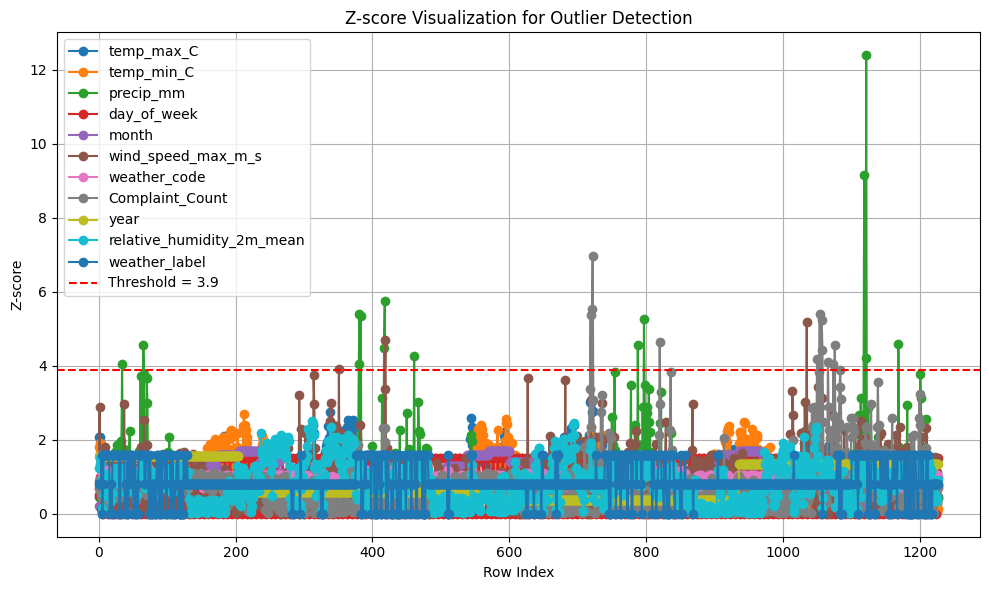

In [13]:
# Step 5: Visualize Z-scores
plt.figure(figsize=(10, 6))
for col in z_scores_df.columns:
    plt.plot(z_scores_df.index, z_scores_df[col], marker='o', label=col)

plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Z-score Visualization for Outlier Detection')
plt.xlabel('Row Index')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

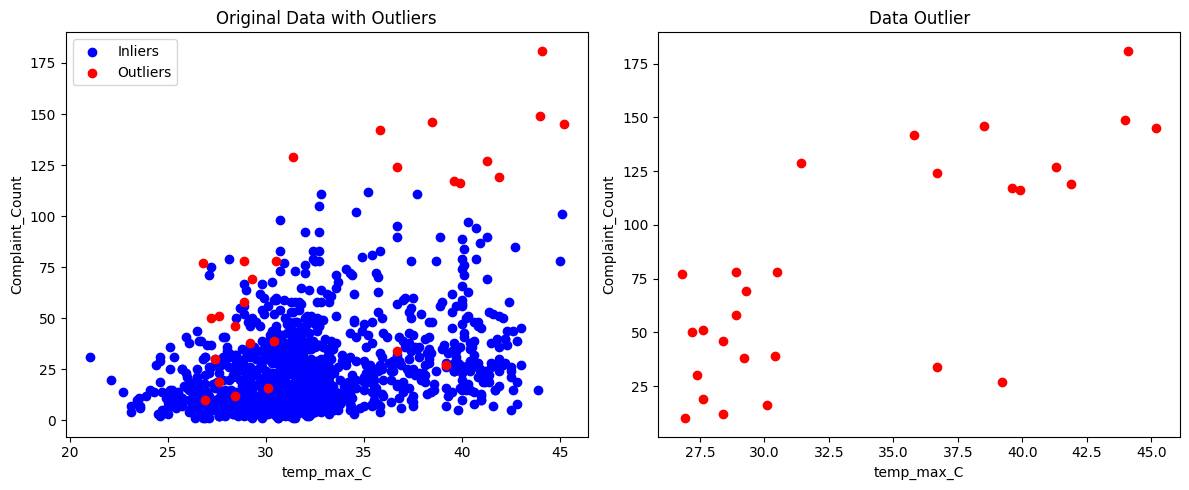

In [14]:
import matplotlib.pyplot as plt

# Step 5: Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define outliers
outliers = ~filtered_entries

# Choose two numeric features for plotting (adjust as needed)
x_col = 'temp_max_C'
y_col = 'Complaint_Count'

# Plot original data with outliers in red
axes[0].scatter(df.loc[filtered_entries, x_col], df.loc[filtered_entries, y_col], color='blue', label='Inliers')
axes[0].scatter(df.loc[outliers, x_col], df.loc[outliers, y_col], color='red', label='Outliers')
axes[0].set_title('Original Data with Outliers')
axes[0].set_xlabel(x_col)
axes[0].set_ylabel(y_col)
axes[0].legend()

# Plot cleaned data
axes[1].scatter(outlier_df[x_col], outlier_df[y_col], color='red')
axes[1].set_title('Data Outlier')
axes[1].set_xlabel(x_col)
axes[1].set_ylabel(y_col)

plt.tight_layout()
plt.show()


In [15]:
df.head(2)

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,30.3,0.1,4,6,16.6,51,10,2022,47,1
1,2022-06-11,41.0,30.8,0.2,5,6,25.3,51,12,2022,42,1


In [16]:
df.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'precip_mm', 'day_of_week', 'month',
       'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'year',
       'relative_humidity_2m_mean', 'weather_label'],
      dtype='object')

### Interquartile Range (IQR) Method:

In [17]:
import pandas as pd

# Example: assuming you already have a DataFrame `df`
# Step 1: Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Step 2: Calculate IQR for each column
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Step 3: Define filter condition (keep only non-outliers)
# This will create a boolean DataFrame and then select rows with all True
filtered_df = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 4: Reset index (optional)
filtered_df = filtered_df.reset_index(drop=True)


In [18]:
print("Original Shape:", df.shape)
print("Filtered Shape:", filtered_df.shape)

Original Shape: (1228, 12)
Filtered Shape: (941, 12)


In [19]:
outlier_mask = (numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))
outlier_count = outlier_mask.sum()
print(outlier_count)

temp_max_C                    58
temp_min_C                     0
precip_mm                    175
day_of_week                    0
month                          0
wind_speed_max_m_s            21
weather_code                   0
Complaint_Count               64
year                           0
relative_humidity_2m_mean      0
weather_label                  0
dtype: int64


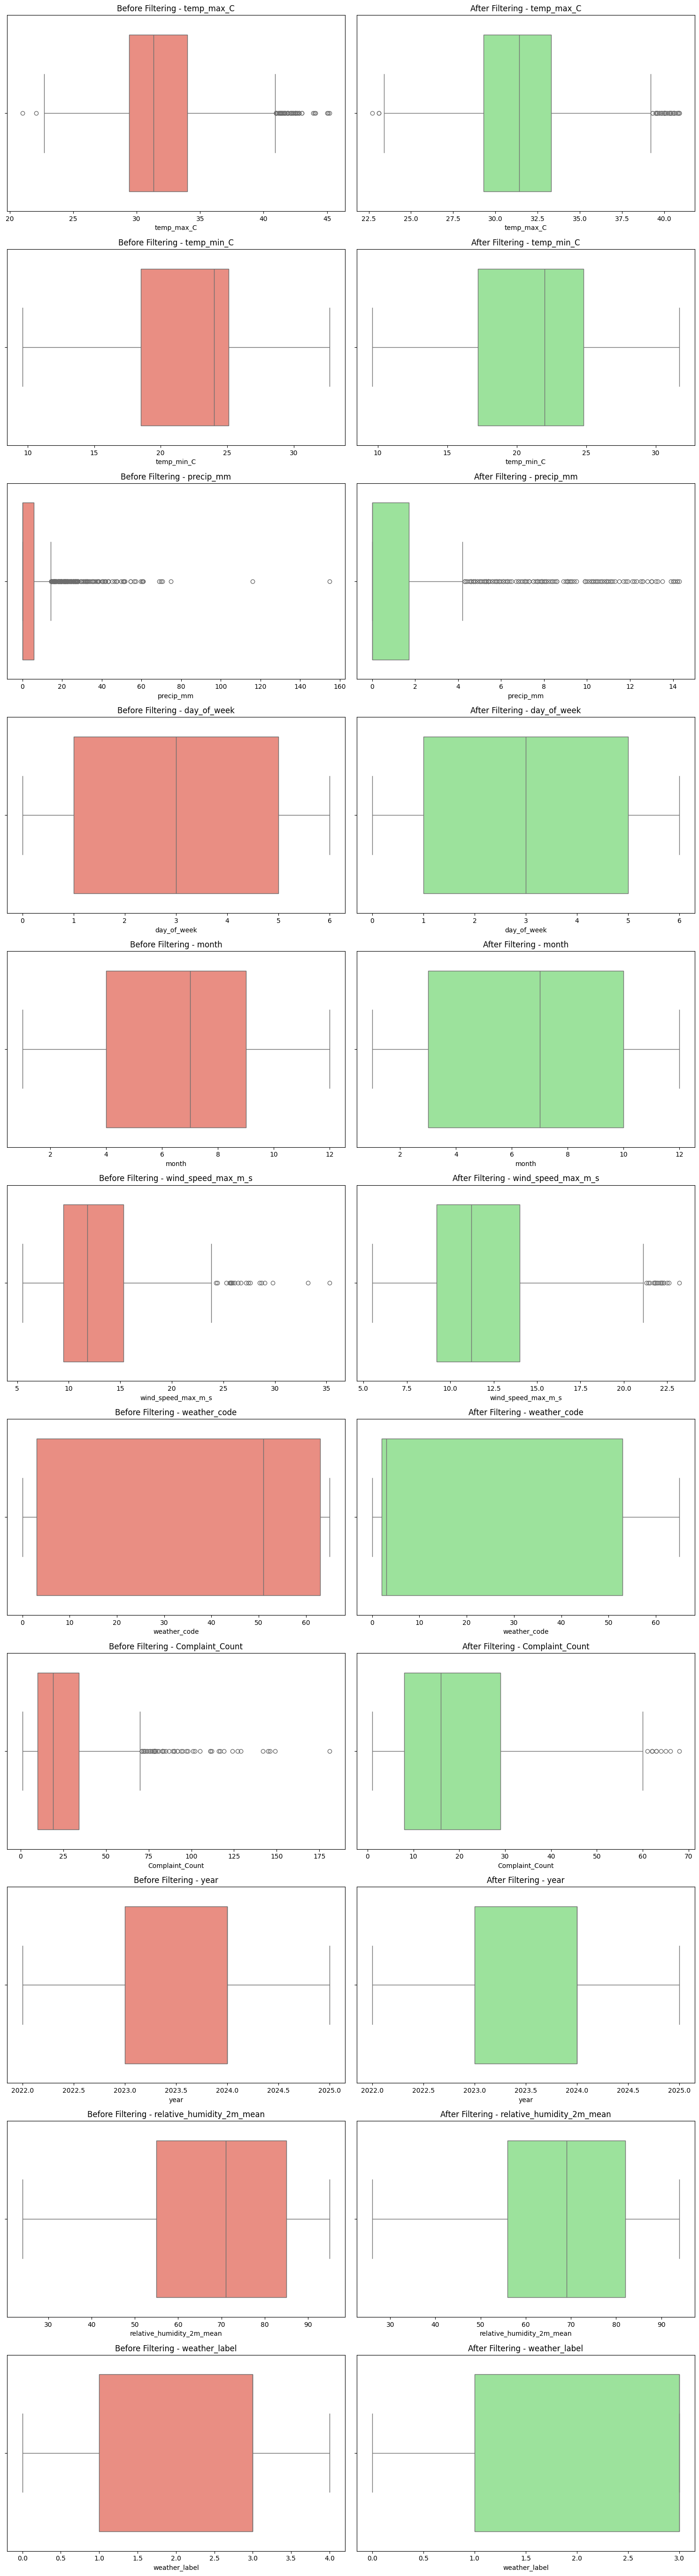

In [20]:
# --- Step 4: Visualization before vs after filtering ---
numeric_cols = numeric_df.columns

# Set figure size
plt.figure(figsize=(15, 5 * len(numeric_cols)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 2, 2*i - 1)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f"Before Filtering - {col}")

    plt.subplot(len(numeric_cols), 2, 2*i)
    sns.boxplot(x=filtered_df[col], color='lightgreen')
    plt.title(f"After Filtering - {col}")

plt.tight_layout()
plt.show()

In [21]:
filtered_df.head()

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-12,39.8,29.5,0.0,6,6,16.7,3,5,2022,45,3
1,2022-06-13,40.2,29.5,0.0,0,6,13.3,3,15,2022,45,3
2,2022-06-14,39.2,30.0,8.6,1,6,19.0,63,16,2022,52,0
3,2022-06-15,35.6,26.1,6.0,2,6,17.4,63,15,2022,66,2
4,2022-06-16,36.8,26.5,0.6,3,6,15.3,53,11,2022,68,1


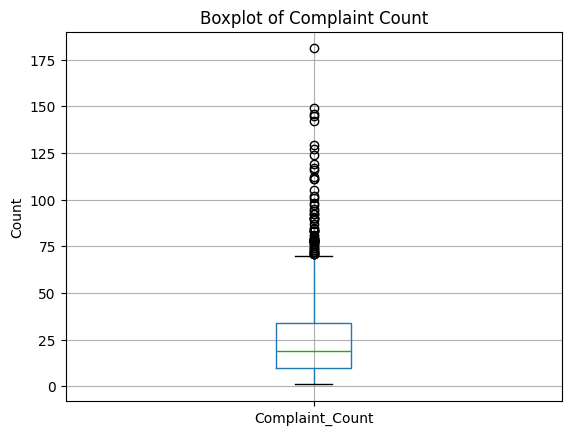

In [22]:
df.boxplot(column='Complaint_Count')
plt.title('Boxplot of Complaint Count')
plt.ylabel('Count')
plt.show()

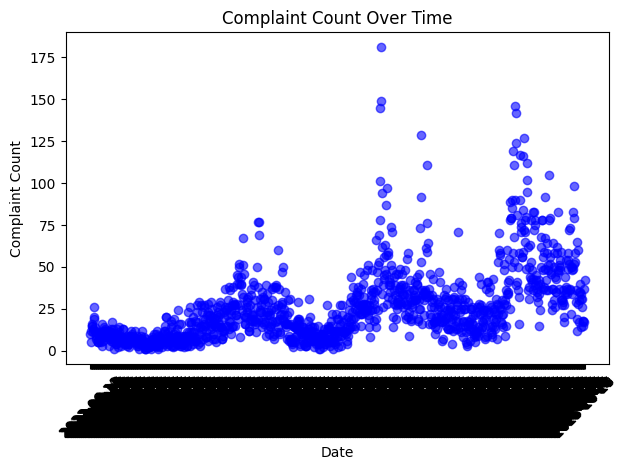

In [23]:
plt.scatter(df['time'], df['Complaint_Count'], color='blue', alpha=0.6)
plt.title('Complaint Count Over Time')
plt.xlabel('Date')
plt.ylabel('Complaint Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Outlier bounds → Lower: -26.00, Upper: 70.00
Original Shape: (1228, 12)
Filtered Shape: (1164, 12)


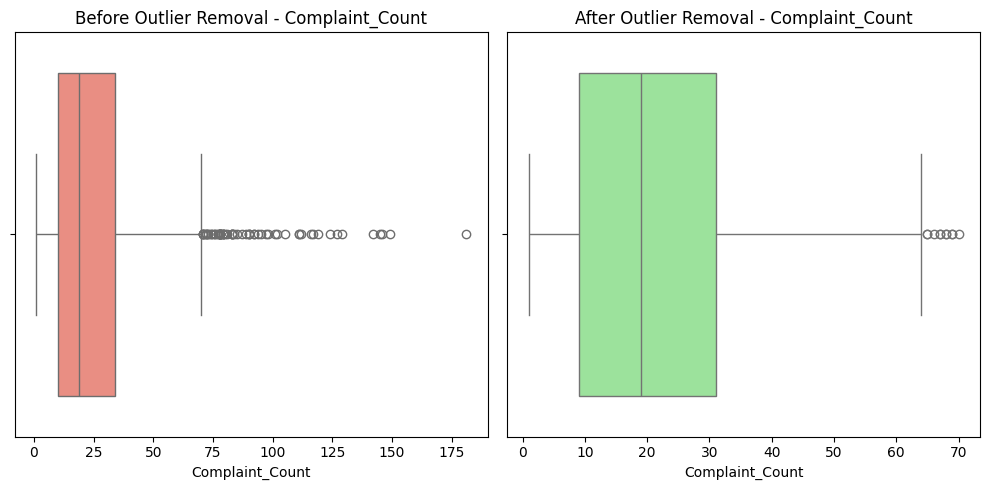

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define your target column name ---
target_col = 'Complaint_Count'   # 🔁 change this to your target column name

# --- Step 2: Compute IQR for the target column ---
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1

# --- Step 3: Define lower and upper bounds ---
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# --- Step 4: Filter DataFrame based on target only ---
filtered_d = df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)]

# --- Step 5: Reset index (optional) ---
filtered_d = filtered_d.reset_index(drop=True)

print(f"Outlier bounds → Lower: {lower_bound:.2f}, Upper: {upper_bound:.2f}")
print("Original Shape:", df.shape)
print("Filtered Shape:", filtered_d.shape)

# --- Step 6: Visualization (before vs after) ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[target_col], color='salmon')
plt.title(f"Before Outlier Removal - {target_col}")

plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_d[target_col], color='lightgreen')
plt.title(f"After Outlier Removal - {target_col}")

plt.tight_layout()
plt.show()


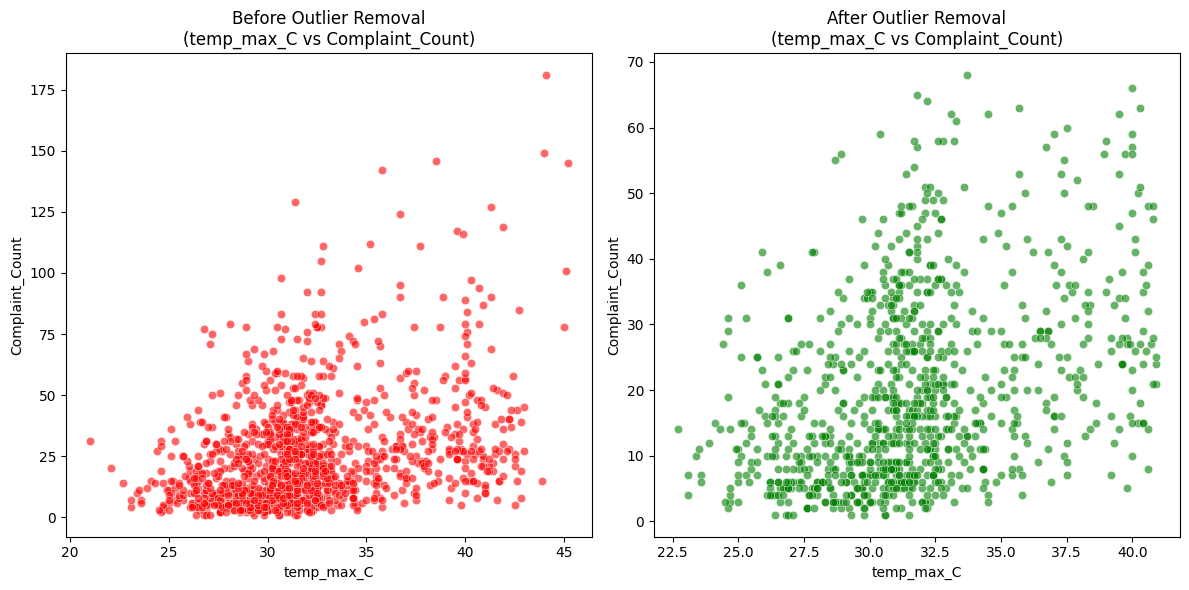

In [25]:
# Before outlier removal
plt.figure(figsize=(12, 6))
x_feature = 'temp_max_C'
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x=x_feature , y=target_col, color='red', alpha=0.6)
plt.title(f"Before Outlier Removal\n({x_feature} vs {target_col})")

# After outlier removal
plt.subplot(1, 2, 2)
sns.scatterplot(data=filtered_df, x=x_feature, y=target_col, color='green', alpha=0.6)
plt.title(f"After Outlier Removal\n({x_feature} vs {target_col})")

plt.tight_layout()
plt.show()

Outlier bounds → Lower: -38.00, Upper: 82.00
Original shape: (1228, 12)
Filtered shape: (1194, 12)


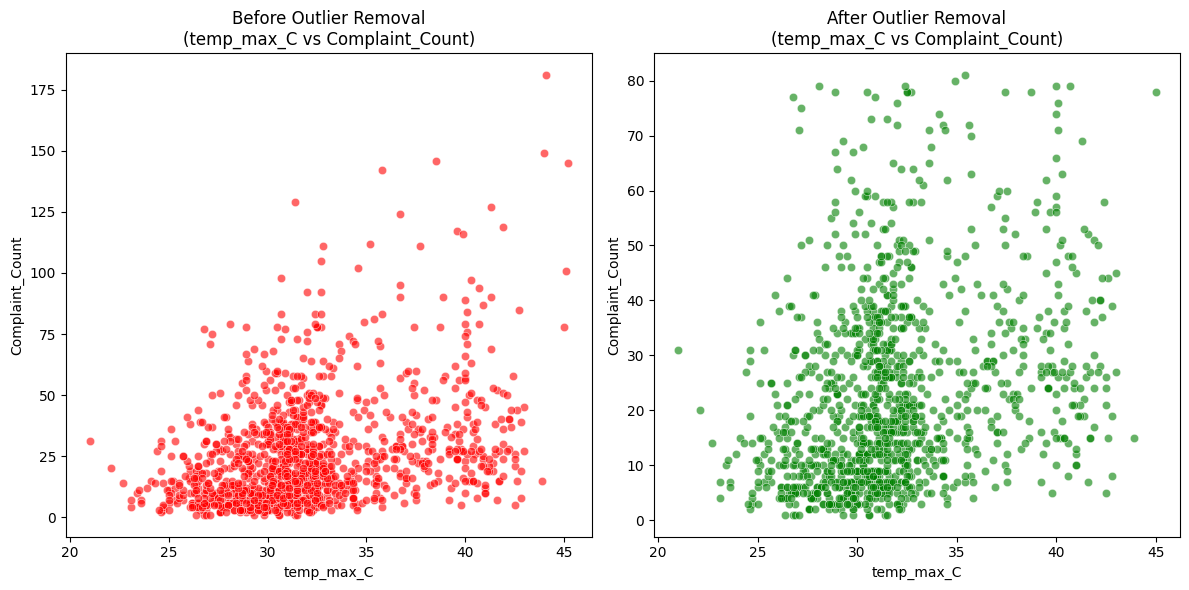

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

target_col = 'Complaint_Count'      # your target variable
x_feature = 'temp_max_C'  # your chosen x-axis feature
factor = 2.0               # 👈 adjust this (1.0, 1.5, 2.0, 3.0...)

Q = df[target_col].quantile(0.25)
Q1 = df[target_col].quantile(0.75)
I = Q1 - Q

lower = Q - factor * I
upper = Q1 + factor * I

filtered_f = df[(df[target_col] >= lower) & (df[target_col] <= upper)]
filtered_f = filtered_f.reset_index(drop=True)

print(f"Outlier bounds → Lower: {lower:.2f}, Upper: {upper:.2f}")
print("Original shape:", df.shape)
print("Filtered shape:", filtered_f.shape)

# Scatter plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x=x_feature, y=target_col, color='red', alpha=0.6)
plt.title(f"Before Outlier Removal\n({x_feature} vs {target_col})")

plt.subplot(1, 2, 2)
sns.scatterplot(data=filtered_f, x=x_feature, y=target_col, color='green', alpha=0.6)
plt.title(f"After Outlier Removal\n({x_feature} vs {target_col})")

plt.tight_layout()
plt.show()


In [27]:
print('ok')

ok


In [28]:
df.describe()

,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
count,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000
mean,32.138355,21.951140,5.645847,3.004886,6.676710,12.762622,30.630293,25.571661,2023.606678,68.773616,2.003257
std,4.291665,4.592986,12.035461,2.001216,3.317319,4.337403,28.983065,22.271619,1.024168,17.753750,1.253516
min,21.000000,9.600000,0.000000,0.000000,1.000000,5.500000,0.000000,1.000000,2022.000000,24.000000,0.000000
25%,29.400000,18.500000,0.000000,1.000000,4.000000,9.500000,3.000000,10.000000,2023.000000,55.000000,1.000000
50%,31.350000,24.000000,0.100000,3.000000,7.000000,11.800000,51.000000,19.000000,2024.000000,71.000000,3.000000
75%,34.000000,25.100000,5.725000,5.000000,9.000000,15.300000,63.000000,34.000000,2024.000000,85.000000,3.000000
max,45.200000,32.700000,154.800000,6.000000,12.000000,35.300000,65.000000,181.000000,2025.000000,95.000000,4.000000


Manual Outlier Cutoffs → Lower: 2, Upper: 80
Original Shape: (1228, 12)
Filtered Shape: (1183, 12)


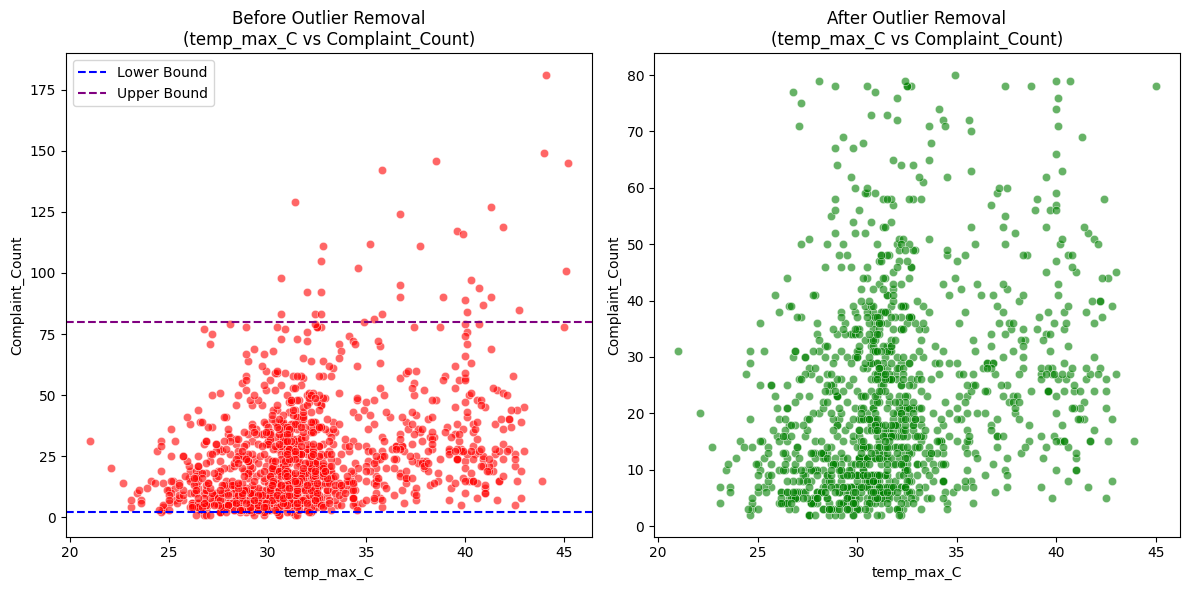

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define your columns ---
target_col = 'Complaint_Count'        # 🔁 your target column
x_feature = 'temp_max_C'    # 🔁 your x-axis feature (e.g., 'humidity', 'day', etc.)

# --- Step 2: Define manual cutoff values ---
lowerbound = 2     # 👈 set your lower limit
upperbound = 80    # 👈 set your upper limit

# --- Step 3: Apply filtering based on manual cutoffs ---
filtered_data = df[(df[target_col] >= lowerbound) & (df[target_col] <= upperbound)]
filtered_data = filtered_data.reset_index(drop=True)

print(f"Manual Outlier Cutoffs → Lower: {lowerbound}, Upper: {upperbound}")
print("Original Shape:", df.shape)
print("Filtered Shape:", filtered_data.shape)

# --- Step 4: Scatter Plot Visualization ---
plt.figure(figsize=(12, 6))

# Before outlier removal
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x=x_feature, y=target_col, color='red', alpha=0.6)
plt.axhline(lowerbound, color='blue', linestyle='--', label='Lower Bound')
plt.axhline(upperbound, color='purple', linestyle='--', label='Upper Bound')
plt.legend()
plt.title(f"Before Outlier Removal\n({x_feature} vs {target_col})")

# After outlier removal
plt.subplot(1, 2, 2)
sns.scatterplot(data=filtered_data, x=x_feature, y=target_col, color='green', alpha=0.6)
plt.title(f"After Outlier Removal\n({x_feature} vs {target_col})")

plt.tight_layout()
plt.show()


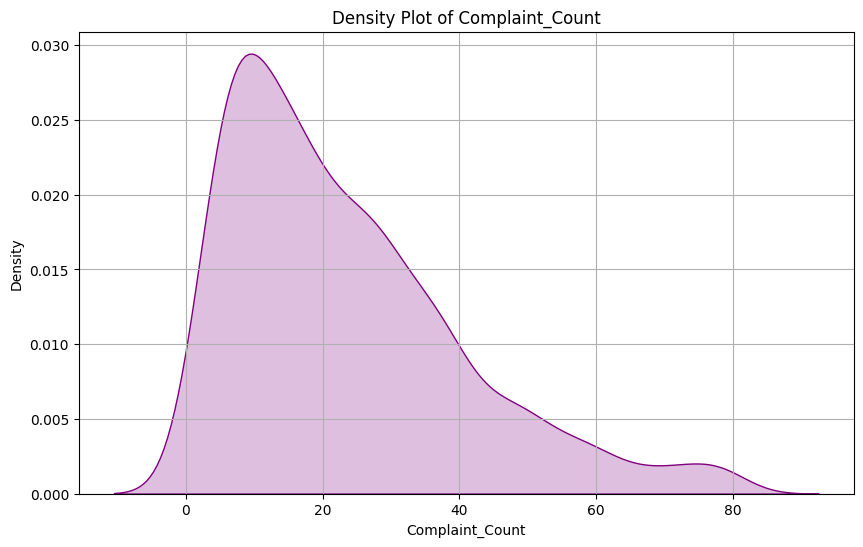

In [30]:
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['Complaint_Count'], shade=True, color='purple')
plt.title('Density Plot of Complaint_Count')
plt.xlabel('Complaint_Count')
plt.ylabel('Density')
plt.grid(True)
plt.show()

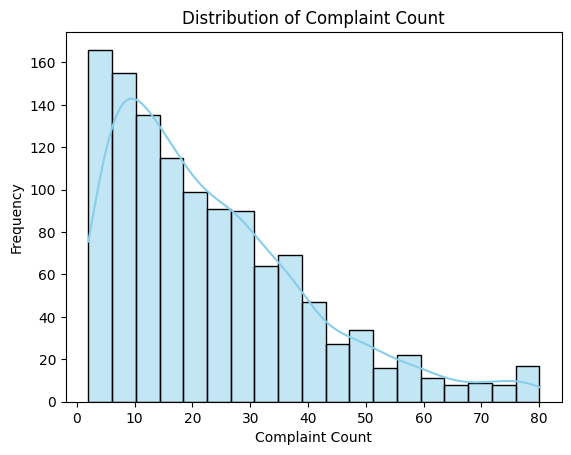

In [31]:
sns.histplot(data=filtered_data, x='Complaint_Count', kde=True, color='skyblue')
plt.title('Distribution of Complaint Count')
plt.xlabel('Complaint Count')
plt.ylabel('Frequency')
plt.show()

In [32]:
filtered_data.head(2)

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,30.3,0.1,4,6,16.6,51,10,2022,47,1
1,2022-06-11,41.0,30.8,0.2,5,6,25.3,51,12,2022,42,1


In [33]:
filtered_data.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'precip_mm', 'day_of_week', 'month',
       'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'year',
       'relative_humidity_2m_mean', 'weather_label'],
      dtype='object')

In [34]:
data =filtered_data[['time', 'temp_max_C', 'precip_mm', 'day_of_week', 'month',
       'wind_speed_max_m_s', 'Complaint_Count', 'year',
       'relative_humidity_2m_mean', 'weather_label']]

In [35]:
data.head(2)

,time,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,0.1,4,6,16.6,10,2022,47,1
1,2022-06-11,41.0,0.2,5,6,25.3,12,2022,42,1


In [36]:
data.isnull().sum()

time                         0
temp_max_C                   0
precip_mm                    0
day_of_week                  0
month                        0
wind_speed_max_m_s           0
Complaint_Count              0
year                         0
relative_humidity_2m_mean    0
weather_label                0
dtype: int64

In [37]:
import pandas as pd
import numpy as np
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data, target_col=None):
    # 1️⃣ Drop target column if provided
    if target_col and target_col in data.columns:
        dat = data.drop(columns=[target_col])
    else:
        dat = data.copy()
    
    # 2️⃣ Keep only numeric columns (VIF requires numeric data)
    dat = dat.select_dtypes(include=[np.number])
    
    # 3️⃣ Replace inf/-inf with NaN, then drop rows with NaN
    dat = dat.replace([np.inf, -np.inf], np.nan).dropna()
    
    # 4️⃣ Add constant for intercept
    V = add_constant(dat)
    
    # 5️⃣ Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = V.columns
    vif_data["VIF"] = [variance_inflation_factor(V.values, i)
                       for i in range(V.shape[1])]
    
    # 6️⃣ Drop constant column
    vif_data = vif_data[vif_data["Feature"] != "const"].reset_index(drop=True)
    
    return vif_data


In [38]:
vif_results = calculate_vif(data, target_col="Complaint_Count")
print(vif_results)

                     Feature       VIF
0                 temp_max_C  2.077096
1                  precip_mm  1.644973
2                day_of_week  1.002562
3                      month  1.633789
4         wind_speed_max_m_s  1.469697
5                       year  1.164297
6  relative_humidity_2m_mean  4.254646
7              weather_label  1.844914


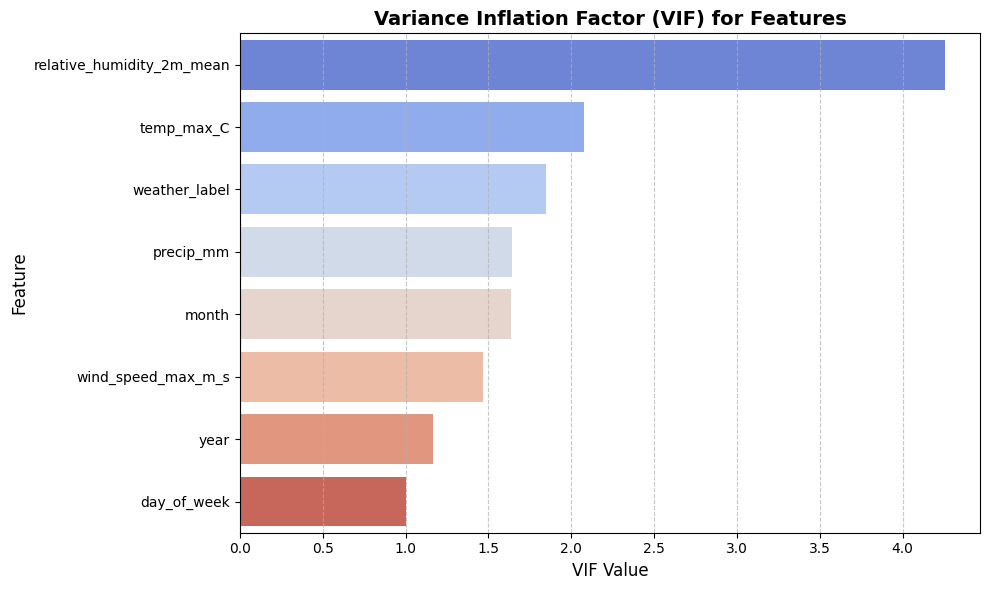

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualization of VIF values ---
plt.figure(figsize=(10, 6))
sns.barplot(x='VIF',y='Feature',data=vif_results.sort_values(by='VIF', ascending=False), palette='coolwarm')
plt.title('Variance Inflation Factor (VIF) for Features', fontsize=14, fontweight='bold')
plt.xlabel('VIF Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [40]:
# --- Variance Threshold Function ---
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_variance_threshold(data, target_col=None, threshold=0.0):
    """
    Identify low-variance features that can be removed to reduce redundancy.

    Parameters:
        data (DataFrame): The dataset containing features and target.
        target_col (str): Optional target column to exclude.
        threshold (float): Minimum variance required to keep a feature.
    """
    # 1️⃣ Drop target column if provided
    if target_col and target_col in data.columns:
        dat = data.drop(columns=[target_col])
    else:
        dat = data.copy()

    # 2️⃣ Keep only numeric columns
    dat = dat.select_dtypes(include=[np.number])

    # 3️⃣ Apply VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(dat)

    # 4️⃣ Collect feature variances
    variances = selector.variances_
    var_df = pd.DataFrame({
        'Feature': dat.columns,
        'Variance': variances
    }).sort_values(by='Variance', ascending=False).reset_index(drop=True)
    
    return var_df


In [41]:
variance_results = calculate_variance_threshold(data, target_col="Complaint_Count", threshold=0.01)
print(variance_results)

                     Feature    Variance
0  relative_humidity_2m_mean  313.853131
1                  precip_mm  147.579504
2         wind_speed_max_m_s   18.360206
3                 temp_max_C   17.540495
4                      month   11.174623
5                day_of_week    3.964486
6              weather_label    1.572248
7                       year    1.029063


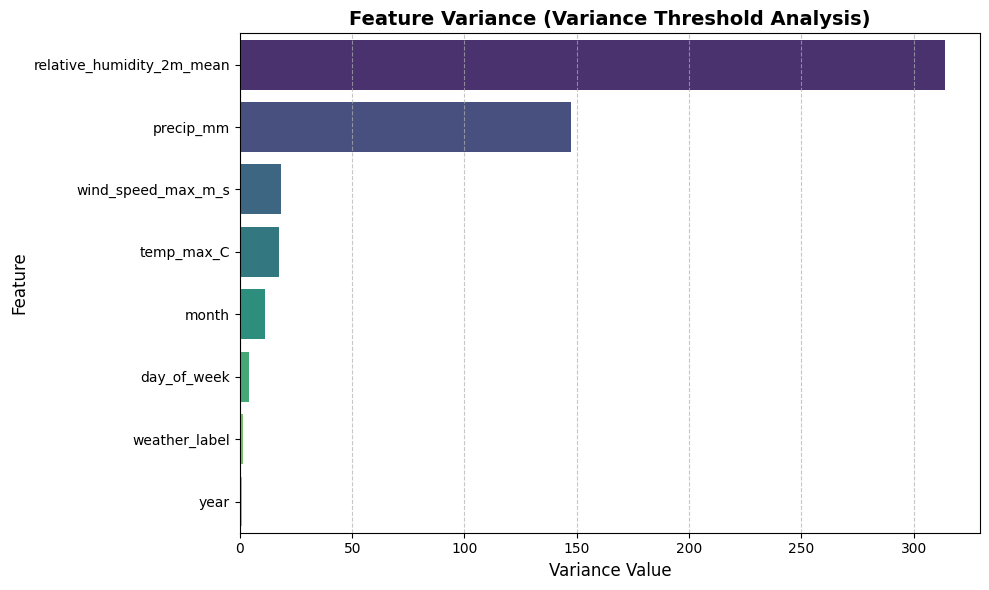

In [42]:
# --- Visualization of Feature Variances ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Variance',
    y='Feature',
    data=variance_results.sort_values(by='Variance', ascending=False),
    palette='viridis'
)

plt.title('Feature Variance (Variance Threshold Analysis)', fontsize=14, fontweight='bold')
plt.xlabel('Variance Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [43]:
data.head()

,time,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,0.1,4,6,16.6,10,2022,47,1
1,2022-06-11,41.0,0.2,5,6,25.3,12,2022,42,1
2,2022-06-12,39.8,0.0,6,6,16.7,5,2022,45,3
3,2022-06-13,40.2,0.0,0,6,13.3,15,2022,45,3
4,2022-06-14,39.2,8.6,1,6,19.0,16,2022,52,0


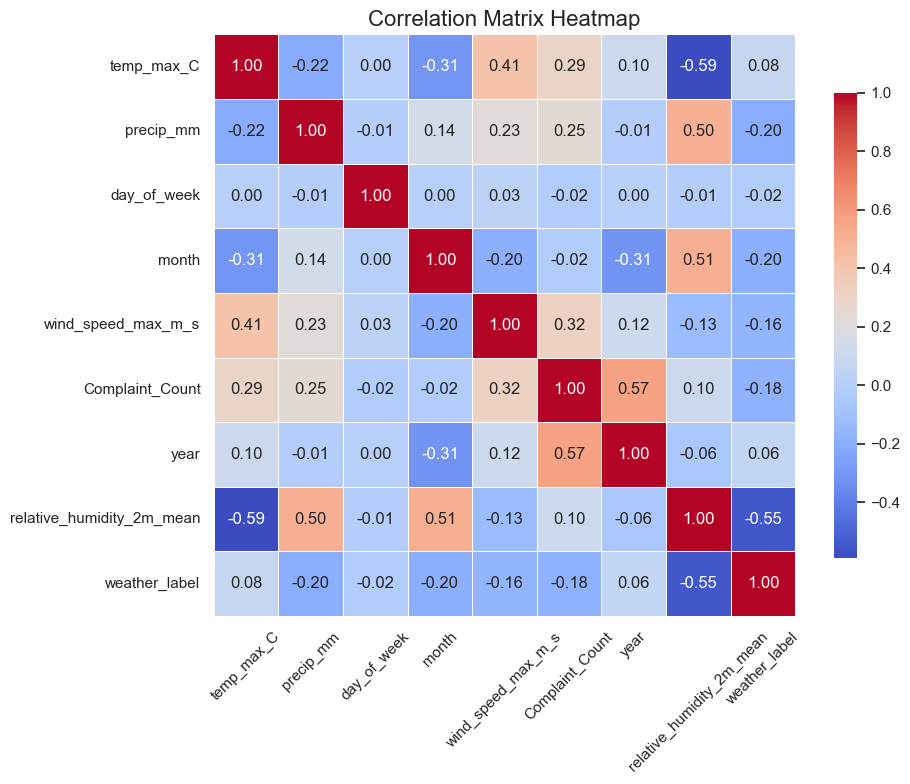

In [44]:
# Calculate correlation matrix
correlation_metrics = data.corr(numeric_only=True)

# Set plot size and style
plt.figure(figsize=(10, 8))
sns.set(style="white")

# Create heatmap
sns.heatmap(correlation_metrics, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.8})

plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [45]:
data.columns


Index(['time', 'temp_max_C', 'precip_mm', 'day_of_week', 'month',
       'wind_speed_max_m_s', 'Complaint_Count', 'year',
       'relative_humidity_2m_mean', 'weather_label'],
      dtype='object')

In [46]:
data.shape

(1183, 10)

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define your columns ---
target_col = 'Complaint_Count'        # 🔁 your target column
# --- Step 2: Define manual cutoff values ---
lowerbound = 2     # 👈 set your lower limit
upperbound = 80    # 👈 set your upper limit

# --- Step 3: Apply filtering based on manual cutoffs ---
filter_data = df[(df[target_col] >= lowerbound) & (df[target_col] <= upperbound)]

print(f"Manual Outlier Cutoffs → Lower: {lowerbound}, Upper: {upperbound}")
print("Original Shape:", df.shape)
print("Filtered Shape:", filter_data.shape)

Manual Outlier Cutoffs → Lower: 2, Upper: 80
Original Shape: (1228, 12)
Filtered Shape: (1183, 12)


In [48]:
filter_data.head()

,time,temp_max_C,temp_min_C,precip_mm,day_of_week,month,wind_speed_max_m_s,weather_code,Complaint_Count,year,relative_humidity_2m_mean,weather_label
0,2022-06-10,41.0,30.3,0.1,4,6,16.6,51,10,2022,47,1
1,2022-06-11,41.0,30.8,0.2,5,6,25.3,51,12,2022,42,1
2,2022-06-12,39.8,29.5,0.0,6,6,16.7,3,5,2022,45,3
3,2022-06-13,40.2,29.5,0.0,0,6,13.3,3,15,2022,45,3
4,2022-06-14,39.2,30.0,8.6,1,6,19.0,63,16,2022,52,0


In [49]:
new_data =filter_data[['time','temp_max_C', 'precip_mm', 'day_of_week', 'month', 'wind_speed_max_m_s',
       'Complaint_Count', 'year', 'relative_humidity_2m_mean',
       'weather_label']]

In [50]:
new_data.set_index('time', inplace=True)

In [51]:
new_data.shape

(1183, 9)

In [52]:
new_data.head(2)

,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,relative_humidity_2m_mean,weather_label
time,,,,,,,,,
2022-06-10,41.0,0.1,4,6,16.6,10,2022,47,1
2022-06-11,41.0,0.2,5,6,25.3,12,2022,42,1


### Check Stationarity (ADF Test) 

In [53]:
# Check Stationarity (ADF Test)


from statsmodels.tsa.stattools import adfuller

def check_stationarity(data, alpha=None):
    """
    Perform the Augmented Dickey-Fuller (ADF) Test to check stationarity.

    Parameters:
    ----------
    series : pandas.Series
        The time series data to test.
    alpha : float, optional (default=0.05)
        Significance level for the test.

    Returns:
    -------
    None
        Prints ADF Test results and conclusion.
    """
    result = adfuller(data.dropna(), autolag='AIC')
    
    print("🧾 Augmented Dickey-Fuller Test Results:")
    print(f"ADF Statistic : {result[0]:.4f}")
    print(f"p-value       : {result[1]:.4f}")
    print(f"Used Lags     : {result[2]}")
    print(f"Number of Observations : {result[3]}")
    print("Critical Values :")
    for key, value in result[4].items():
        print(f"    {key} : {value:.4f}")
    
    # Interpretation
    if result[1] <= alpha:
        print(f"\n✅ The series is **Stationary** (Reject H0) at {alpha*100}% significance level.")
    else:
        print(f"\n❌ The series is **Non-Stationary** (Fail to Reject H0) at {alpha*100}% significance level.")


In [54]:
stationarity = check_stationarity(new_data['Complaint_Count'],alpha=0.05)


🧾 Augmented Dickey-Fuller Test Results:
ADF Statistic : -2.3425
p-value       : 0.1586
Used Lags     : 15
Number of Observations : 1167
Critical Values :
    1% : -3.4360
    5% : -2.8640
    10% : -2.5681

❌ The series is **Non-Stationary** (Fail to Reject H0) at 5.0% significance level.


transform the data before applying most traditional time series models.

In [55]:
new_data['Complaint_Count_diff1'] = new_data['Complaint_Count'].diff().dropna()



In [56]:
new_data

,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,relative_humidity_2m_mean,weather_label,Complaint_Count_diff1
time,,,,,,,,,,
2022-06-10,41.0,0.1,4,6,16.6,10,2022,47,1,NaN
2022-06-11,41.0,0.2,5,6,25.3,12,2022,42,1,2.0
2022-06-12,39.8,0.0,6,6,16.7,5,2022,45,3,-7.0
2022-06-13,40.2,0.0,0,6,13.3,15,2022,45,3,10.0
2022-06-14,39.2,8.6,1,6,19.0,16,2022,52,0,1.0
...,...,...,...,...,...,...,...,...,...,...
2025-10-15,31.4,0.0,2,10,6.1,18,2025,78,3,3.0
2025-10-16,30.9,0.0,3,10,8.2,18,2025,75,3,0.0
2025-10-17,31.0,0.0,4,10,7.8,17,2025,75,3,-1.0


In [57]:

stationarity_01 = check_stationarity(new_data['Complaint_Count_diff1'].dropna(), alpha=0.05)

🧾 Augmented Dickey-Fuller Test Results:
ADF Statistic : -15.1419
p-value       : 0.0000
Used Lags     : 14
Number of Observations : 1167
Critical Values :
    1% : -3.4360
    5% : -2.8640
    10% : -2.5681

✅ The series is **Stationary** (Reject H0) at 5.0% significance level.


### Visualize ACF & PACF (to find p, q)

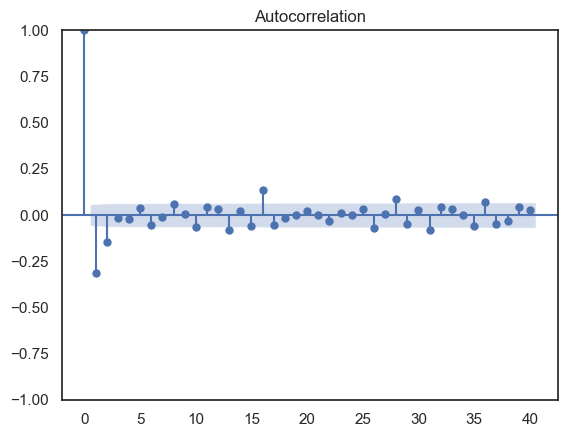

In [58]:
plot_acf(new_data['Complaint_Count_diff1'].dropna(), lags=40)
plt.show()

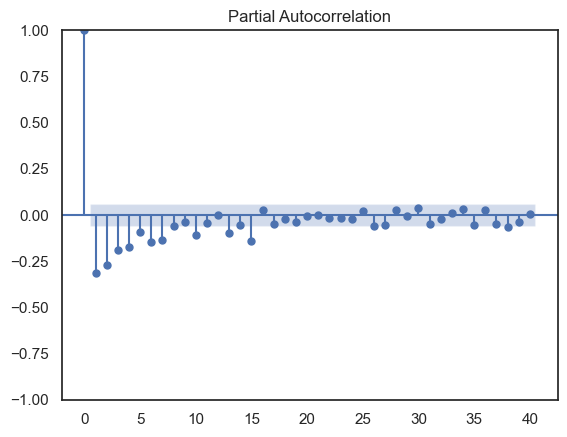

In [59]:
plot_pacf(new_data['Complaint_Count_diff1'].dropna(), lags=40)
plt.show()

### # Model Selection

p=1, d=1, q= 1

In [60]:
# Train-Test Split 

train_size = int(len(new_data) * 0.8)
train, test = new_data['Complaint_Count'][:train_size], new_data['Complaint_Count'][train_size:]



In [61]:
train.shape

(946,)

In [62]:
test.shape

(237,)

In [63]:
from statsmodels.tsa.arima.model import ARIMA

# Define model on the original target (not the diff column)
model = ARIMA(train, order=(1,1,1))  # d=1 because we differenced once
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:        Complaint_Count   No. Observations:                  946
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3445.984
Date:                Wed, 29 Oct 2025   AIC                           6897.967
Time:                        19:40:17   BIC                           6912.521
Sample:                             0   HQIC                          6903.514
                                - 946                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2628      0.028      9.501      0.000       0.209       0.317
ma.L1         -0.9100      0.013    -69.424      0.000      -0.936      -0.884
sigma2        85.9571      2.402     35.785      0.0

In [64]:
# Forecast same length as test
forecast = model_fit.forecast(steps=len(test))

# Combine for comparison
results = test.to_frame(name='Actual')
results['Predicted'] = forecast.values
print(results.head())

            Actual  Predicted
time                         
2025-01-31      44  19.362114
2025-02-01      22  17.092171
2025-02-02      26  16.495655
2025-02-03      13  16.338897
2025-02-04      40  16.297702


In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(results['Actual'], results['Predicted'])
rmse = np.sqrt(mean_squared_error(results['Actual'], results['Predicted']))
mape = np.mean(np.abs((results['Actual'] - results['Predicted']) / results['Actual'])) * 100
r2 = r2_score(results['Actual'], results['Predicted'])

print(f"📊 Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R2 : {r2:.2f}%")


📊 Model Evaluation Metrics:
MAE  : 24.6577
RMSE : 30.1659
MAPE : 54.24%
R2 : -1.68%


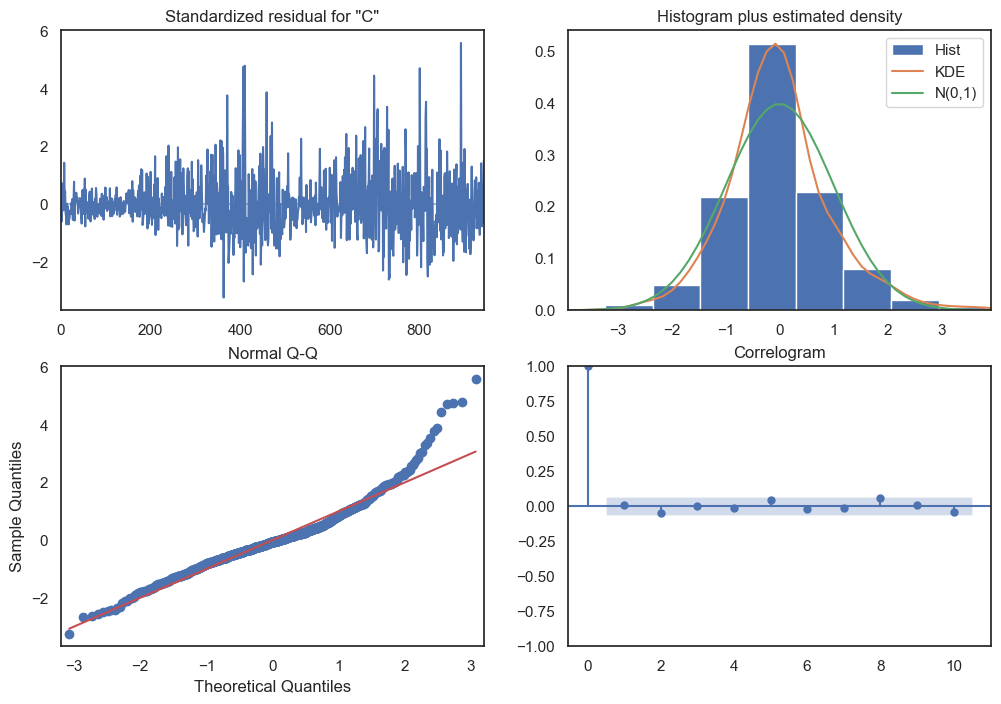

In [66]:
# Plot diagnostic plots
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

# This shows:
# - Standardized residuals (should look like white noise)
# - Histogram + KDE (should be roughly normal)
# - Normal Q-Q plot (points should follow the diagonal)
# - Correlogram (ACF, should be within confidence bands)

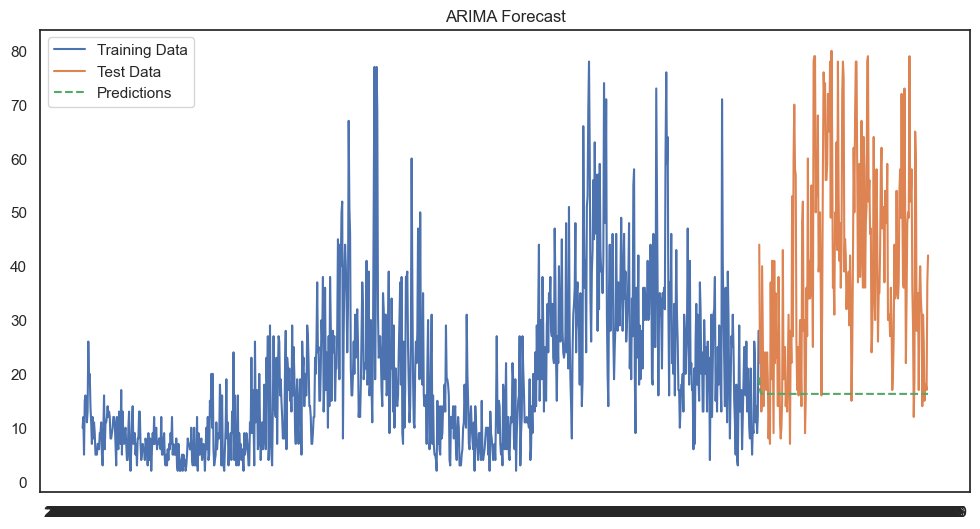

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, forecast, label='Predictions', linestyle='--')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

In [68]:
new_data.columns

Index(['temp_max_C', 'precip_mm', 'day_of_week', 'month', 'wind_speed_max_m_s',
       'Complaint_Count', 'year', 'relative_humidity_2m_mean', 'weather_label',
       'Complaint_Count_diff1'],
      dtype='object')

In [69]:
# Train-Test Split (80-20)


y = new_data['Complaint_Count']
X = new_data[['temp_max_C', 'precip_mm', 'day_of_week', 'month',
              'wind_speed_max_m_s', 'year', 'relative_humidity_2m_mean', 'weather_label']]

train_size = int(len(new_data) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]


In [70]:
model_01 = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 1, 1),              # (p,d,q) - Non-seasonal components
    seasonal_order=(1, 1, 1, 24), # (P,D,Q,s) - Seasonal components, s=24 is for a 24-period season (e.g., daily cycle in hourly data)
    enforce_stationarity=False,
    enforce_invertibility=False
)
# Correction: Use 'model_01' (the defined model object) instead of 'model'
model_result = model_01.fit(disp=False)

In [71]:
pred = model_fit.forecast(steps=len(y_test), exog=X_test)


In [72]:
# Combine actual and predicted values
results_01 = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': pred.values
}, index=y_test.index)

In [73]:
results_01

,Actual,Predicted
time,,
2025-01-31,44,19.362114
2025-02-01,22,17.092171
2025-02-02,26,16.495655
2025-02-03,13,16.338897
2025-02-04,40,16.297702
...,...,...
2025-10-15,18,16.283018
2025-10-16,18,16.283018
2025-10-17,17,16.283018


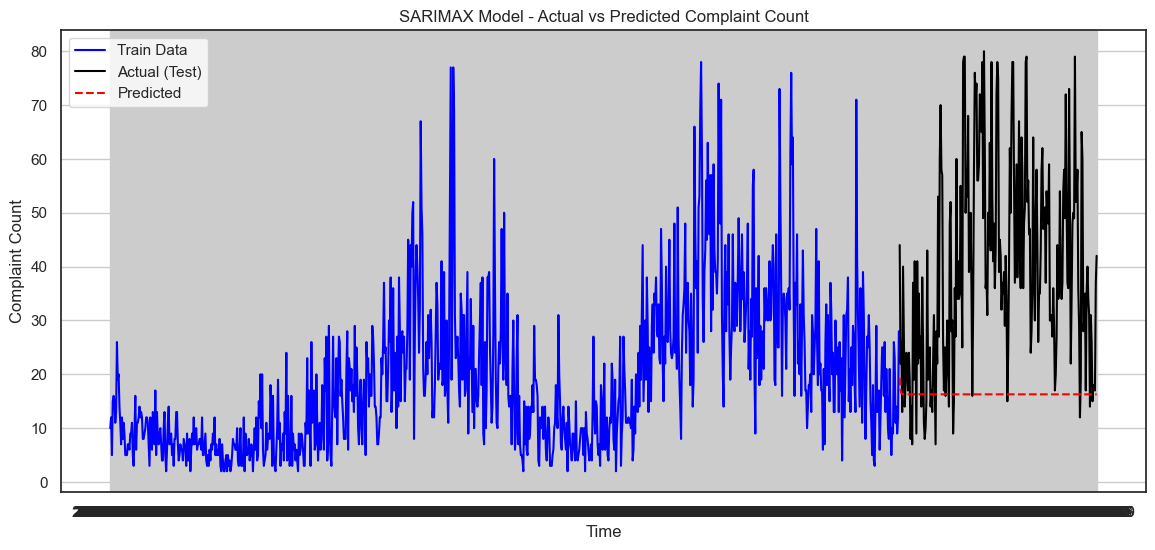

In [74]:
# Visualization: Actual vs Predicted

plt.figure(figsize=(14,6))
plt.plot(y_train.index, y_train, label='Train Data', color='blue')
plt.plot(y_test.index, y_test, label='Actual (Test)', color='black')
plt.plot(y_test.index, results_01['Predicted'], label='Predicted', color='red', linestyle='--')
plt.title('SARIMAX Model - Actual vs Predicted Complaint Count')
plt.xlabel('Time')
plt.ylabel('Complaint Count')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
mae = mean_absolute_error(results_01['Actual'], results_01['Predicted'])
rmse = np.sqrt(mean_squared_error(results_01['Actual'], results_01['Predicted']))
mape = np.mean(np.abs((results_01['Actual'] - results_01['Predicted']) / results['Actual'])) * 100
r2 = r2_score(results_01['Actual'], results_01['Predicted'])

print("\n📈 Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R2 : {r2:.2f}%")


📈 Model Evaluation Metrics:
MAE  : 24.6577
RMSE : 30.1659
MAPE : 54.24%
R2 : -1.68%


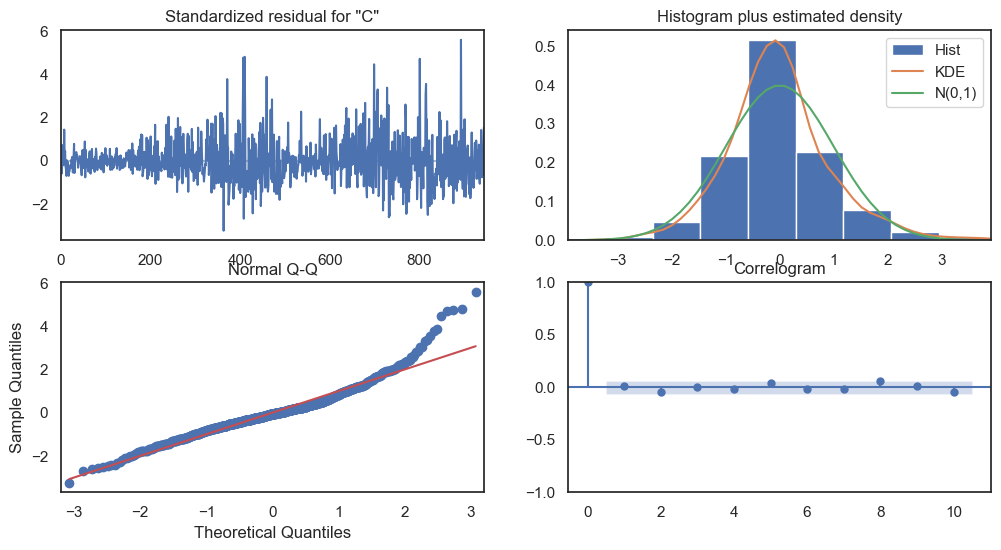

In [76]:
model_fit.plot_diagnostics(figsize=(12,6))
plt.show()

In [81]:
new_data = new_data.reset_index()

In [ ]:
# new_data.to_csv('timeseries_model_data.csv', index=False)

In [82]:
new_data

,time,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,relative_humidity_2m_mean,weather_label,Complaint_Count_diff1
0,2022-06-10,41.0,0.1,4,6,16.6,10,2022,47,1,NaN
1,2022-06-11,41.0,0.2,5,6,25.3,12,2022,42,1,2.0
2,2022-06-12,39.8,0.0,6,6,16.7,5,2022,45,3,-7.0
3,2022-06-13,40.2,0.0,0,6,13.3,15,2022,45,3,10.0
4,2022-06-14,39.2,8.6,1,6,19.0,16,2022,52,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1178,2025-10-15,31.4,0.0,2,10,6.1,18,2025,78,3,3.0
1179,2025-10-16,30.9,0.0,3,10,8.2,18,2025,75,3,0.0
1180,2025-10-17,31.0,0.0,4,10,7.8,17,2025,75,3,-1.0
1181,2025-10-18,30.5,0.0,5,10,6.3,37,2025,77,3,20.0


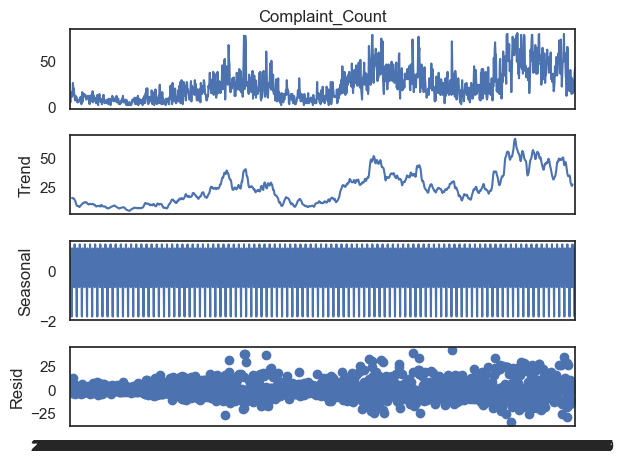

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Choose the column to decompose (e.g., 'demand')
series = new_data['Complaint_Count']

# Perform decomposition (adjust period as needed)
decomposition = seasonal_decompose(series, model='additive', period=12)

# Plot the components
decomposition.plot()
plt.tight_layout()
plt.show()


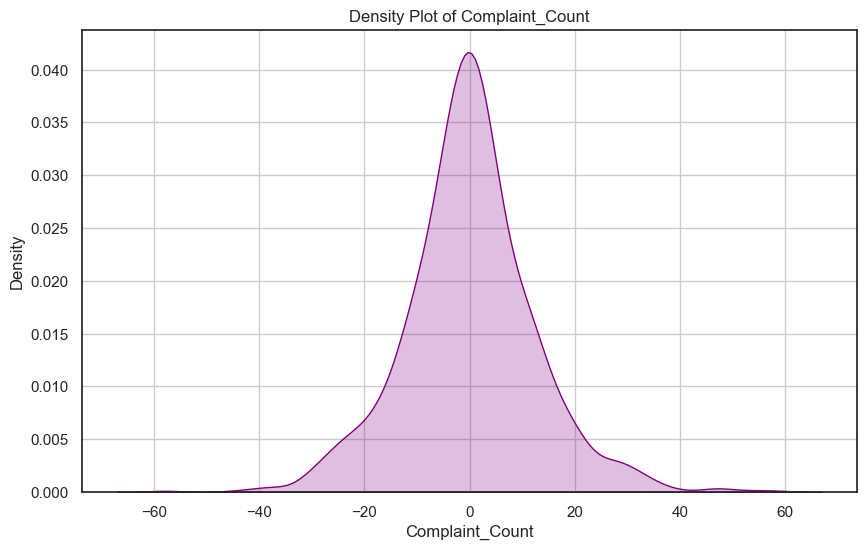

In [80]:
plt.figure(figsize=(10, 6))
sns.kdeplot(new_data['Complaint_Count_diff1'], shade=True, color='purple')
plt.title('Density Plot of Complaint_Count')
plt.xlabel('Complaint_Count')
plt.ylabel('Density')
plt.grid(True)
plt.show()